# Species Classification - SVM Model

## About Dataset

The Iris flower dataset is one of the most popular ones for machine learning. More information can be found [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

## Load Iris Dataset

In [2]:
iris_data = datasets.load_iris()

In [3]:
# Assign petal length and petal width to variable X
X = iris_data["data"][:, (2,3)]

In [4]:
# Variable y contains only iris virginica
y = (iris_data["target"] == 2).astype(np.float64)

## Build Pipeline with StandardScaler and LinearSVC

In [5]:
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
])
svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

### Use the Model to Make Predictions

In [6]:
svm_clf.predict([[3.5, 2.5]])

array([1.])

Unlike the logistic regressin the SVM classifiers do not return probabilities.

## Plot Classification Using Large and Small Hyperparameter C

In [7]:
# Build a models for hyperparameters C=1 and C=100
scaler = StandardScaler()
svm_clf_1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf_2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf_1 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf_1)
])
scaled_svm_clf_2 = Pipeline([
    ("scaler", scaler),
    ("linear_svc", svm_clf_2)
])

scaled_svm_clf_1.fit(X, y)
scaled_svm_clf_2.fit(X, y)

C:\Users\ttomk\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [8]:
# Convert to unscaled parameters
b1 = svm_clf_1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf_2.decision_function([-scaler.mean_ / scaler.scale_])

w1 = svm_clf_1.coef_[0] / scaler.scale_
w2 = svm_clf_2.coef_[0] / scaler.scale_

svm_clf_1.intercept_ = np.array([b1])
svm_clf_2.intercept_ = np.array([b2])

svm_clf_1.coef_ = np.array([w1])
svm_clf_2.coef_ = np.array([w2])

In [9]:
# Find support vectors
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()

svm_clf_1.support_vectors_ = X[support_vectors_idx1]
svm_clf_2.support_vectors_ = X[support_vectors_idx2]

(4.0, 5.9, 0.8, 2.8)

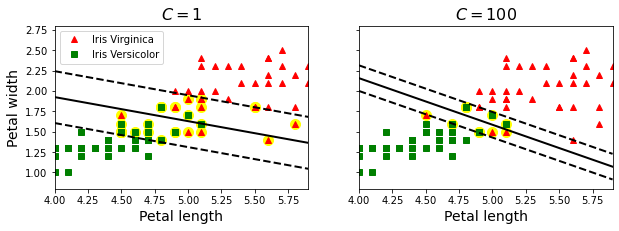

In [10]:
# Plot classifiers
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    # At the decision bourdary, w0*x0 + w1*x1 + b = 0 => x1 = -w0/w1*x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    margin = 1 / w[1]
    up = decision_boundary + margin
    down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=100, facecolors="yellow")
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, up, "k--", linewidth=2)
    plt.plot(x0, down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,3), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r^", label="Iris Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "gs", label="Iris Versicolor")
plot_svc_decision_boundary(svm_clf_1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.title("$C = {}$".format(svm_clf_1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "r^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "gs")
plot_svc_decision_boundary(svm_clf_2, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf_2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

The model with hyperparameter C=1 has a lot of margin violations but it will generalize better.